# Overview
- blending する

# Introduction
- lightGBM
- build distance datasets と fc 関連のみ扱う

# Import everything I need :)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
import multiprocessing
import multiprocessing as multi
from multiprocessing import Pool
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from fastprogress import progress_bar

# Preparation

In [2]:
nb = 90
isSmallSet = False
length = 30000

In [3]:
pd.set_option('display.max_columns', 200)

<br>
<br>
load data

In [4]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/nb47_fc_train.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/nb29_fc_train_feature.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/nb47_fc_test.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupli

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)
scc = train.scalar_coupling_constant.values
type_train = train.type.values
type_train_list = np.unique(type_train)

In [59]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)
type_test = test.type.values
type_test_list = np.unique(type_test)

<br>
<br>
oof and submission data

In [7]:
path_list = np.array([
'nb60_{}_lgb_-1.5330660525700779.csv',
'nb79_{}_extra_trees_regressor_-1.56760.csv',
'nb80_{}_extra_trees_regressor_-1.48000.csv',
'nb81_{}_bagging_regressor_-1.44452.csv',
'nb82_{}_bagging_regressor_-1.36181.csv',
'nb84_{}_extra_trees_regressor_-1.60943.csv',
'nb85_{}_extra_trees_regressor_-1.52972.csv',
'nb88_{}_lgb_-1.547953965914086.csv',
'nb91_{}_extra_trees_regressor_-1.47467.csv',
])

In [8]:
# oof list
oof_dfs = []
for path in path_list:
    if isSmallSet:
        _df = pd.read_csv('./../output/' + path.format('oof'))[:length]
    else:
        _df = pd.read_csv('./../output/' + path.format('oof'))
    oof_dfs.append(_df)

# submission list
sub_dfs = []
for path in path_list:
    if isSmallSet:
        _df = pd.read_csv('./../output/' + path.format('submission'))[:length]
    else:
        _df = pd.read_csv('./../output/' + path.format('submission'))
    sub_dfs.append(_df)

assert len(oof_dfs)==len(sub_dfs), f'oofとsubmissionファイルの数が違います。 n_oof={len(oof_dfs)}, n_sub={len(sub_dfs)}'

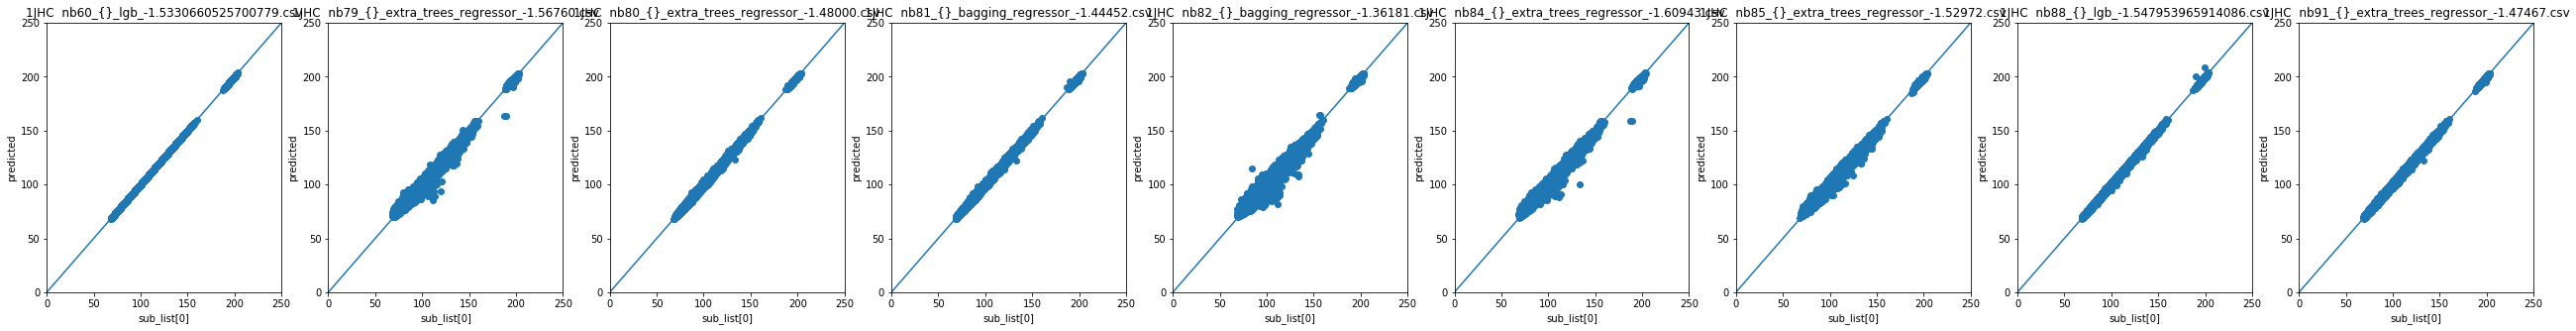

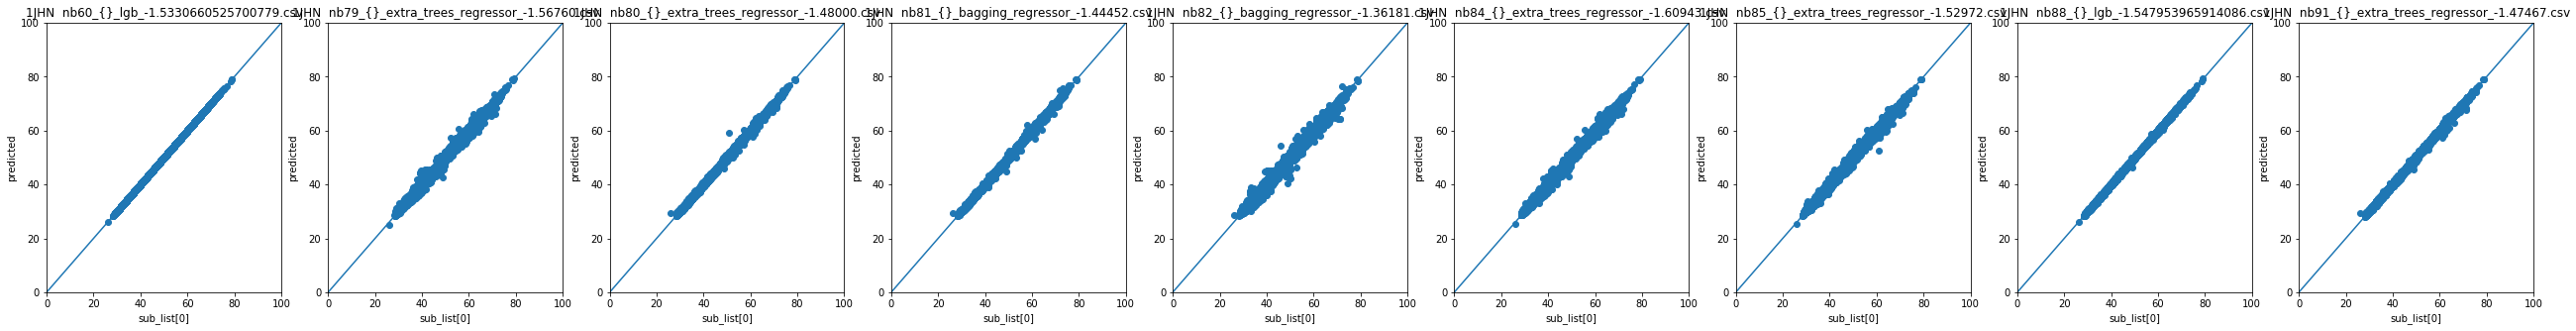

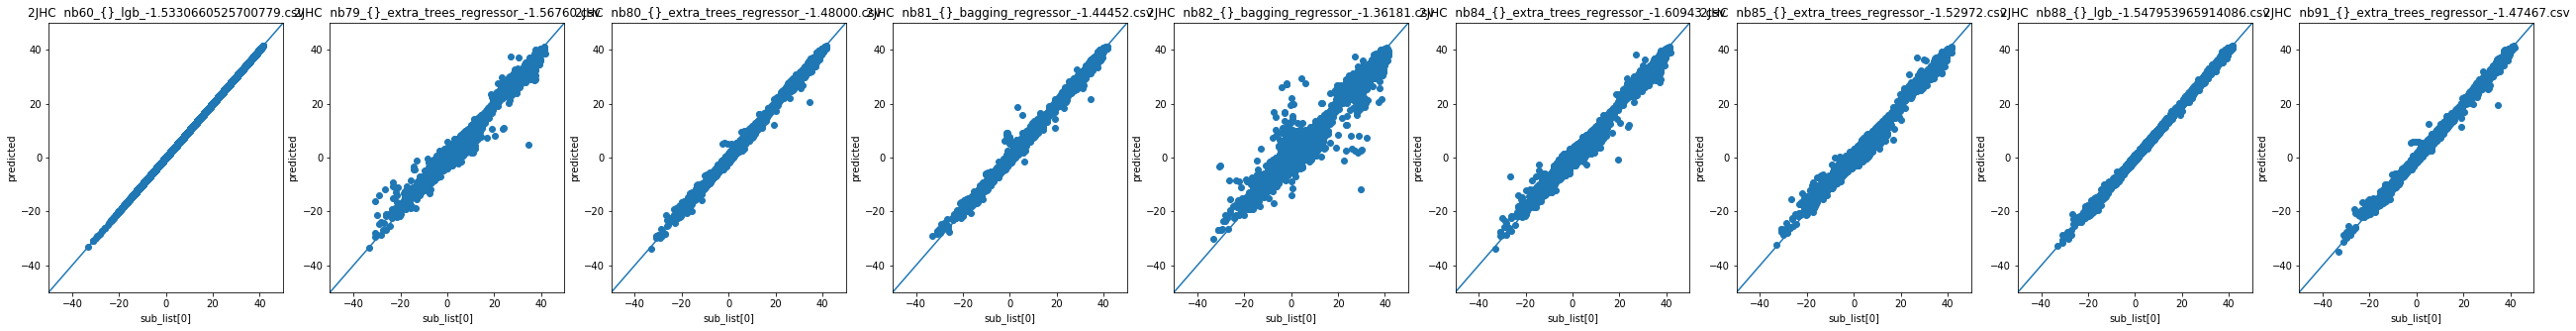

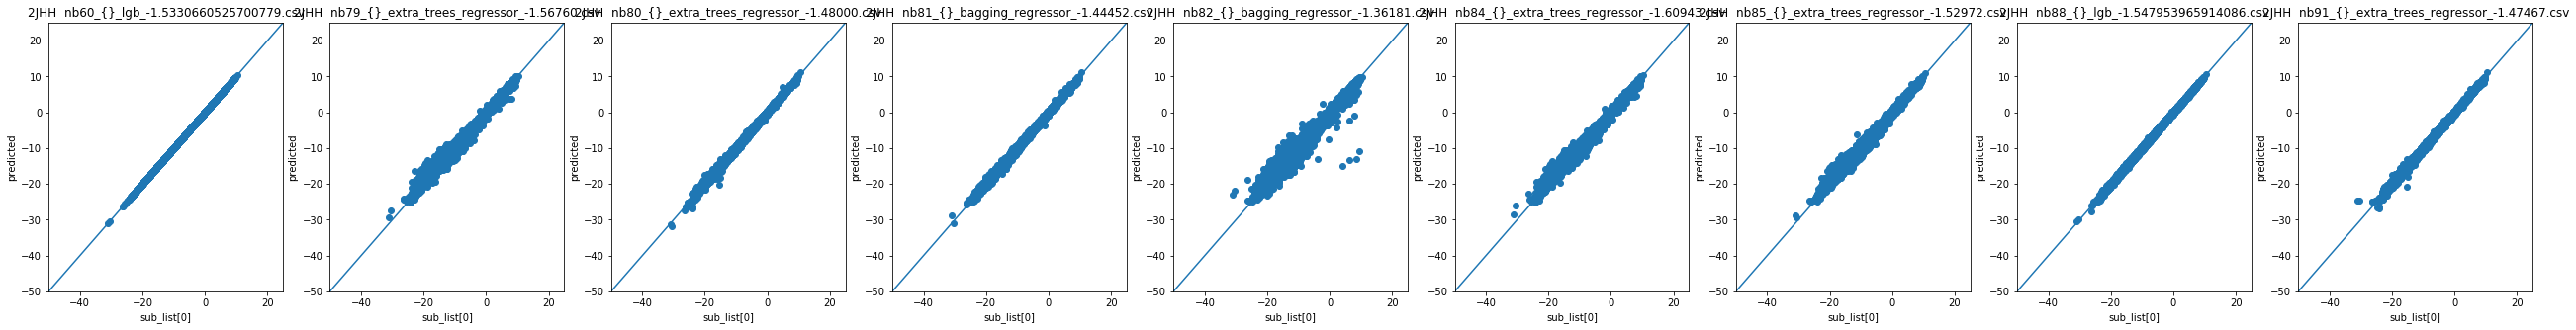

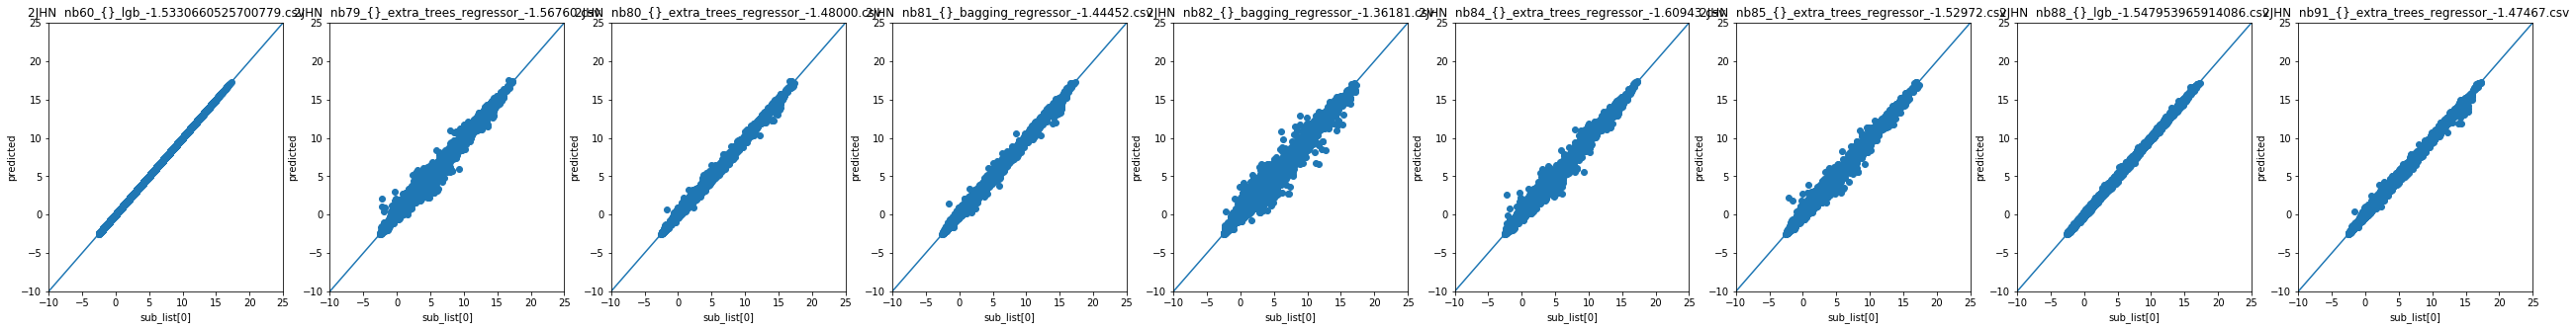

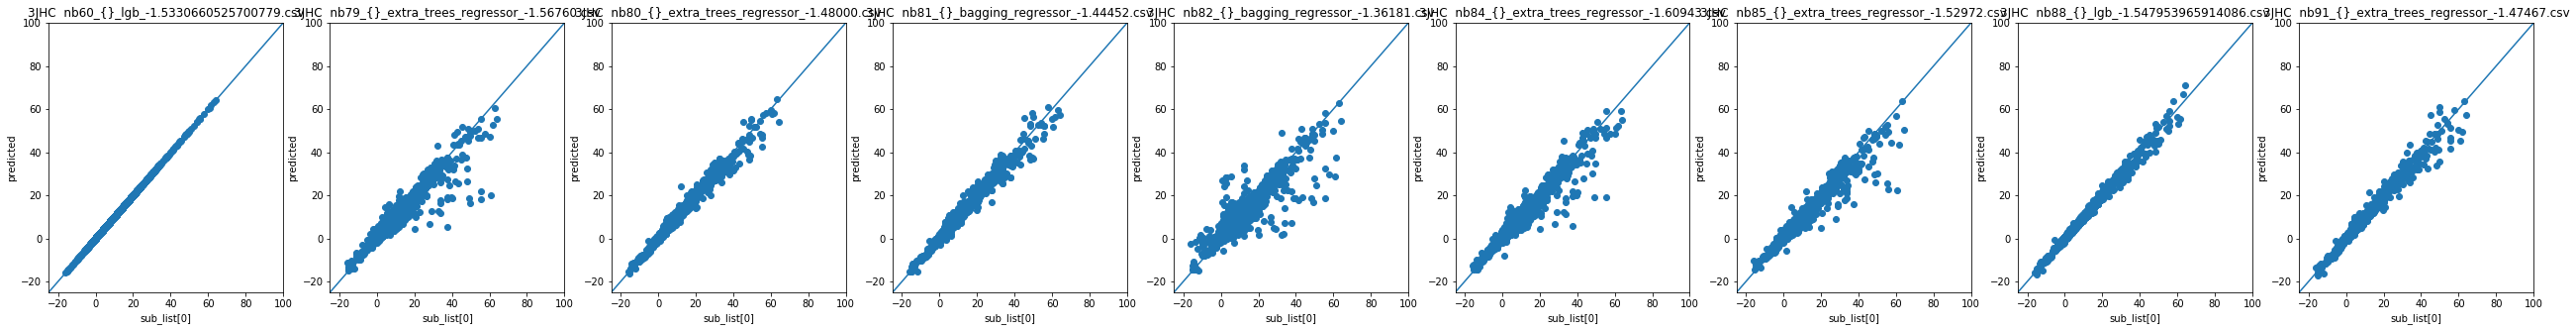

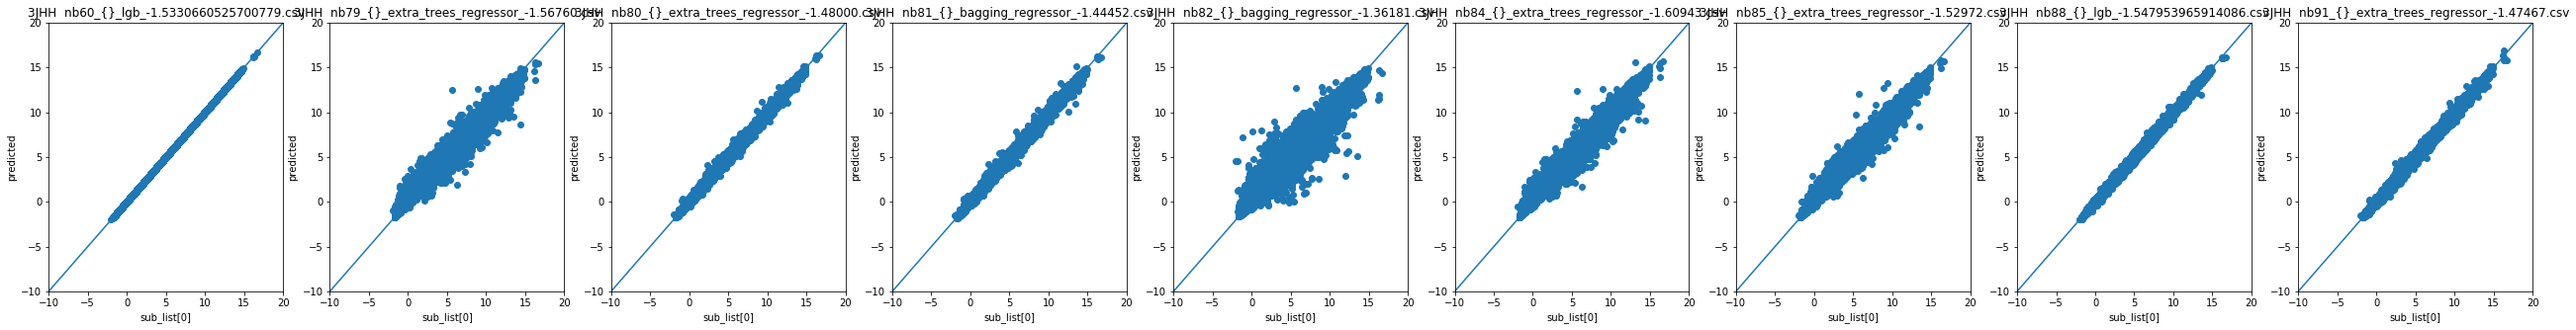

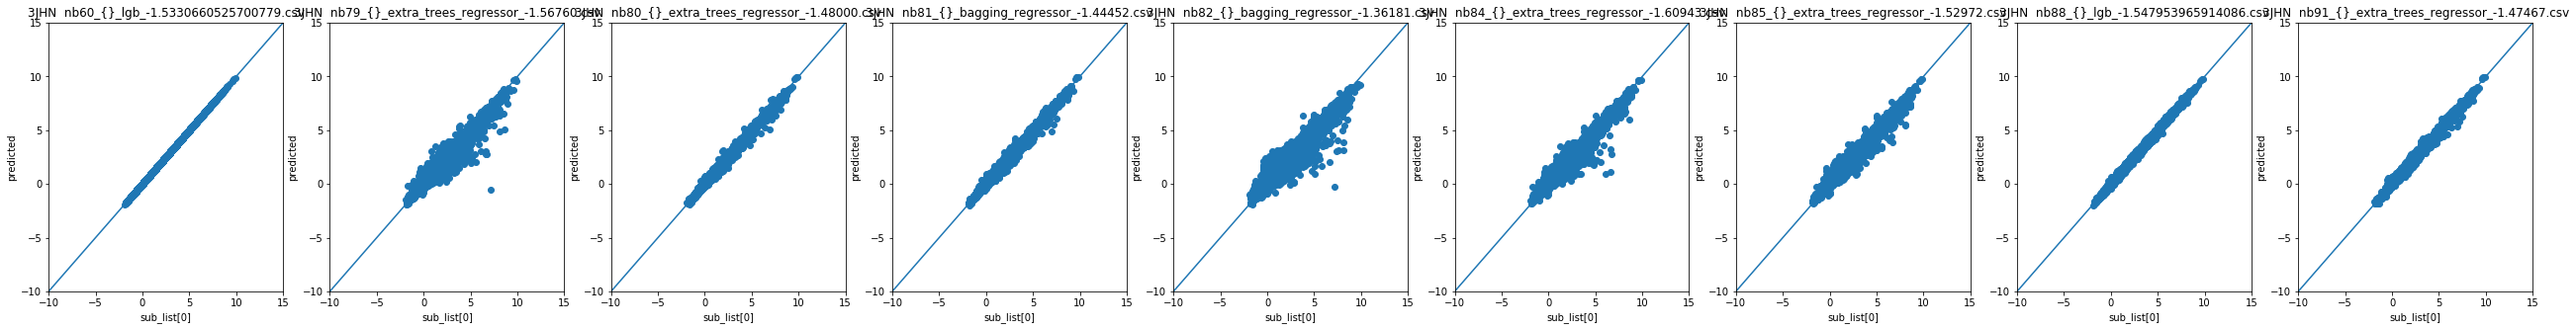

In [61]:
sub_list = [df.scalar_coupling_constant.values for df in sub_dfs ] 
model_names = path_list
# types = lbl.inverse_transform(X['type'])
types = type_test

def plot_oof_preds(ctype, llim, ulim):
    fig, axs = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
    axs = axs.ravel()
    for i in range(len(model_names)):
        model_name = model_names[i]
        t_idx = types==ctype
#         y = train.scalar_coupling_constant.values
        axs[i].scatter(sub_list[0][t_idx], sub_list[i][t_idx])
        axs[i].set_xlim((llim, ulim))
        axs[i].set_ylim((llim, ulim))
        axs[i].plot([llim, ulim], [llim, ulim])
        axs[i].set_xlabel('sub_list[0]')
        axs[i].set_ylabel('predicted')
        axs[i].set_title(f'{ctype}  {model_names[i]}', fontsize=12)
        
plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 25)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -10, 20)
plot_oof_preds('3JHN', -10, 15)

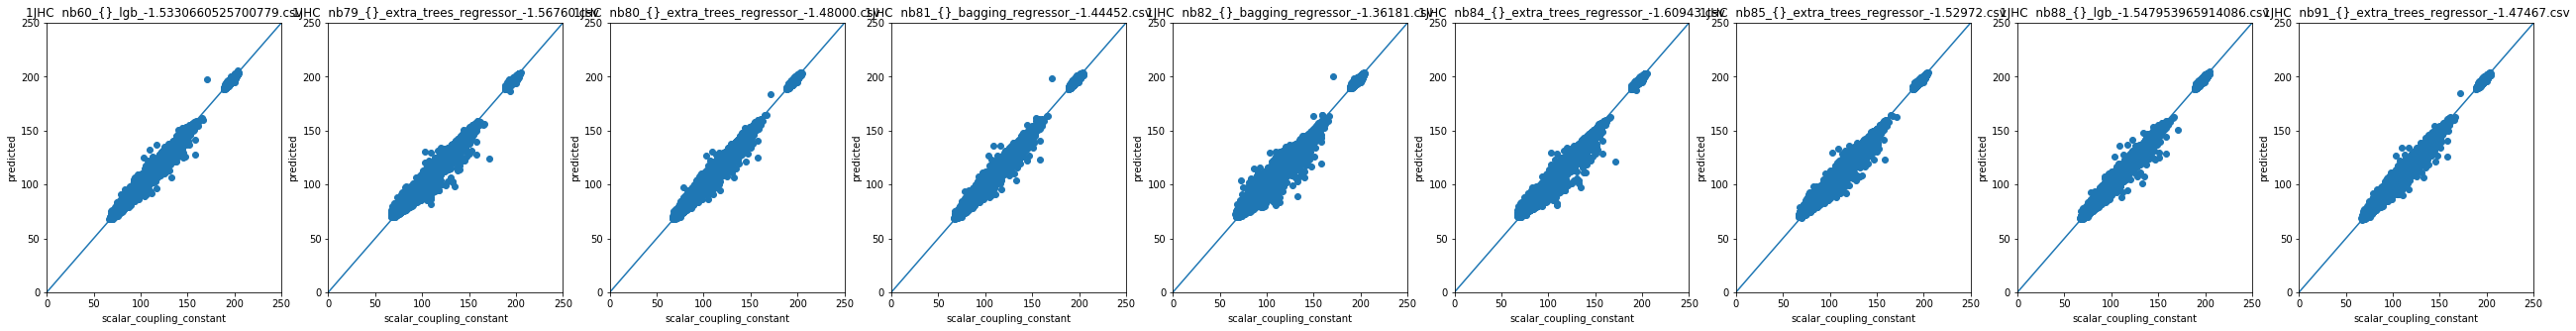

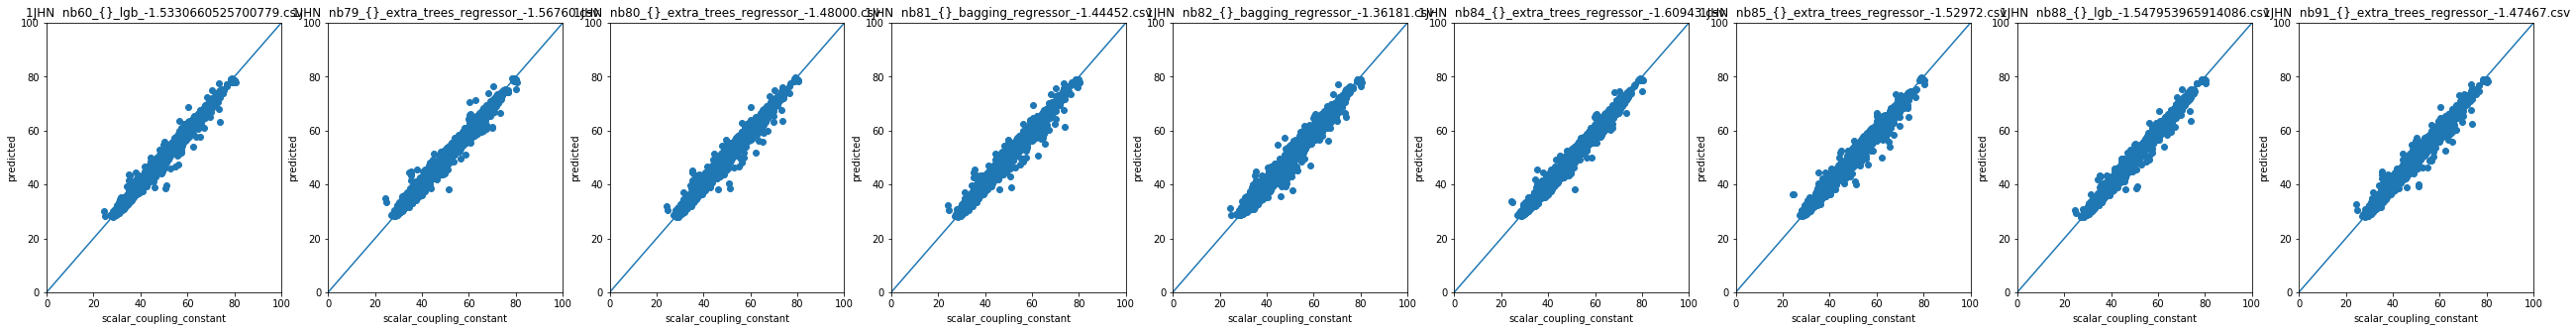

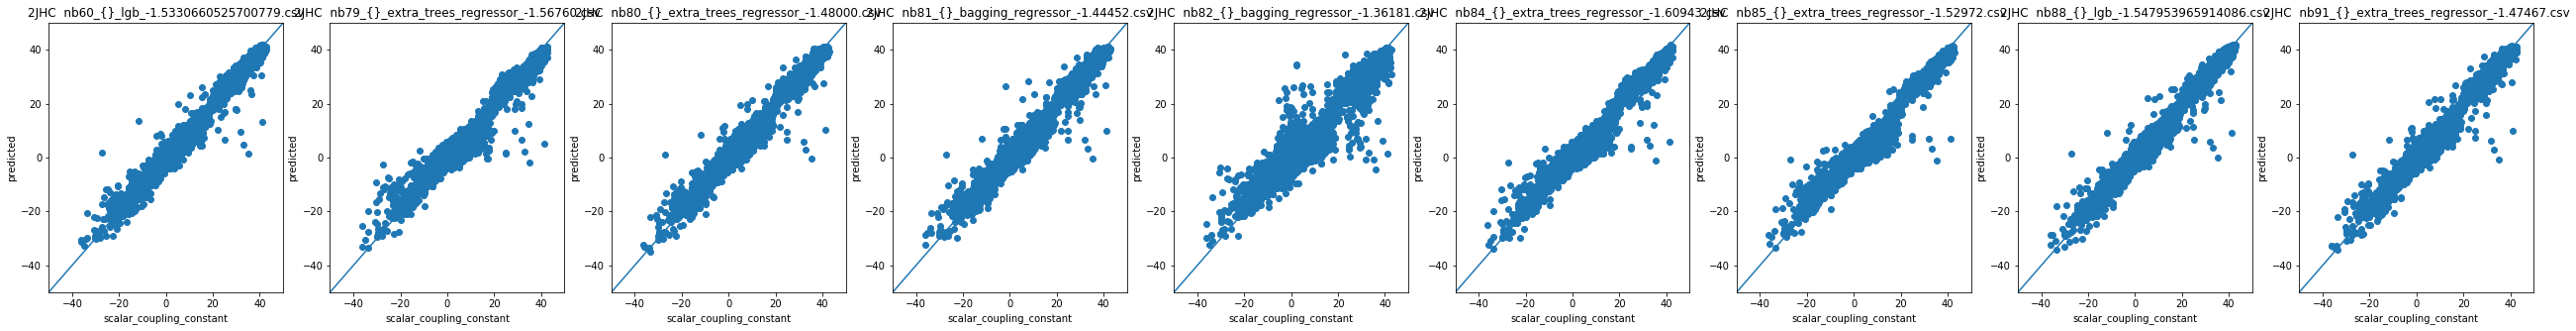

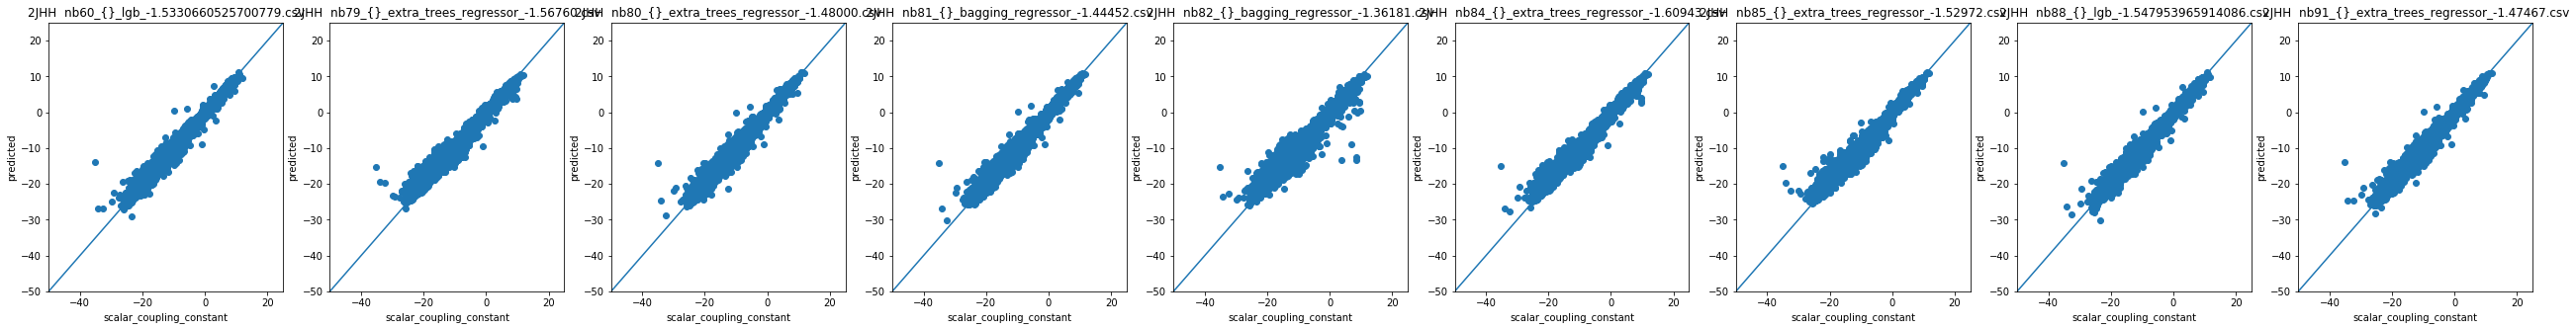

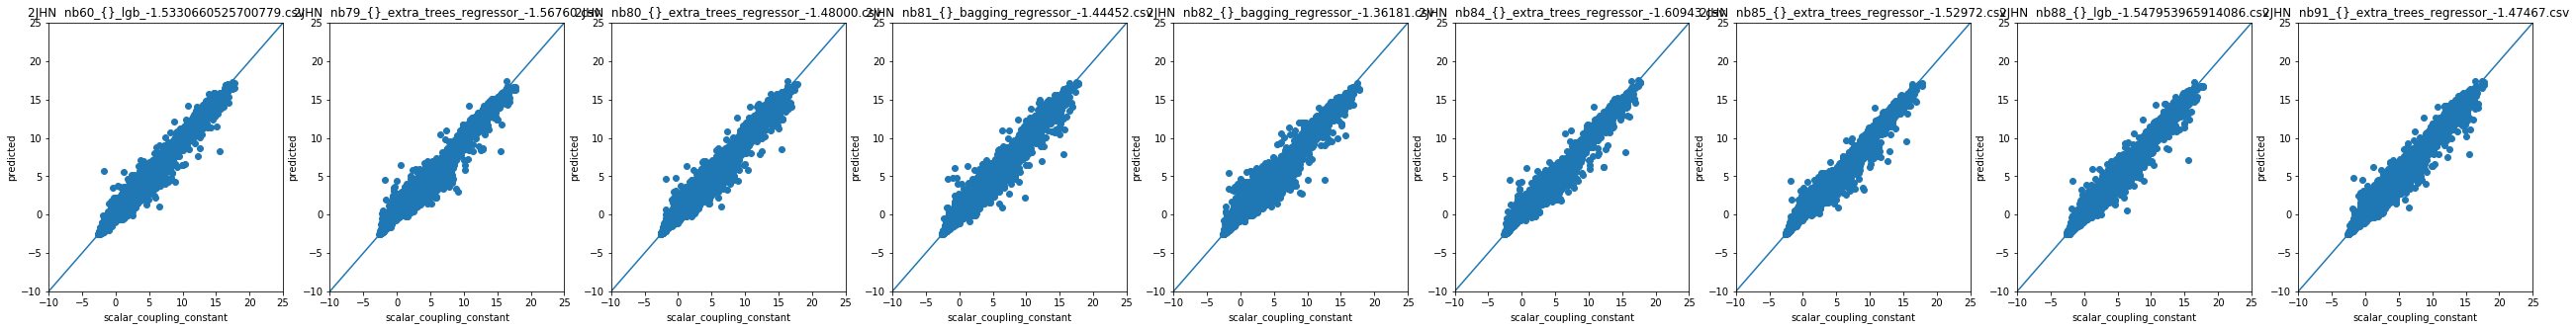

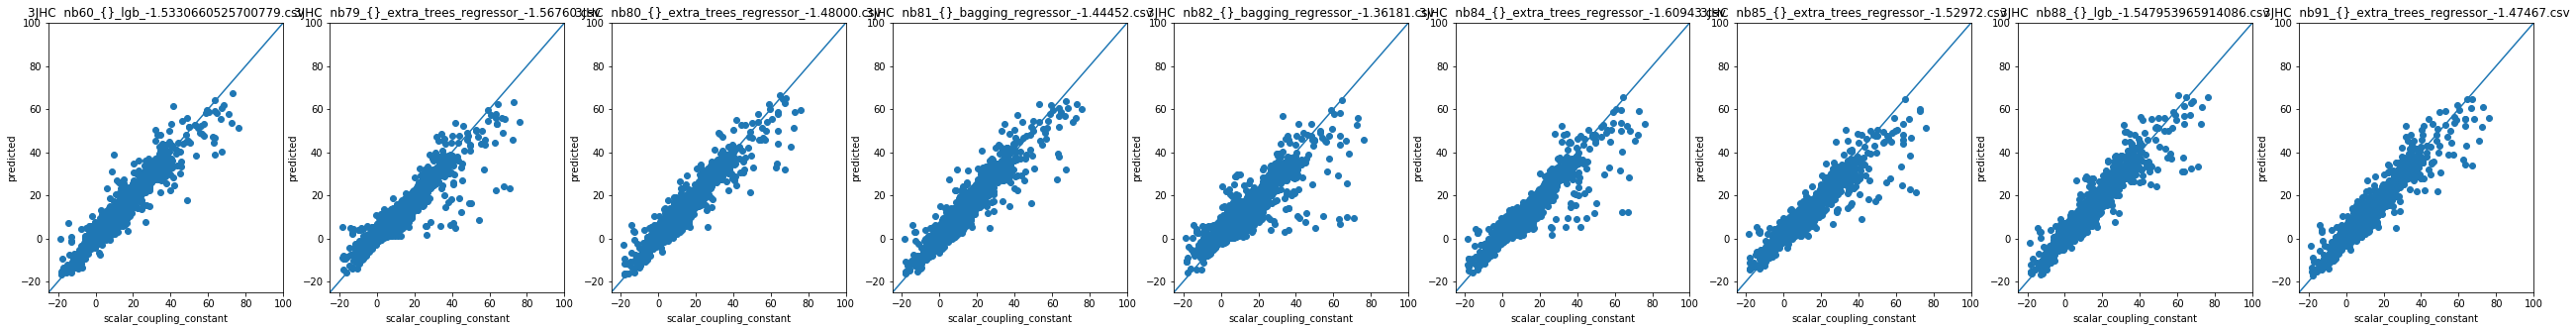

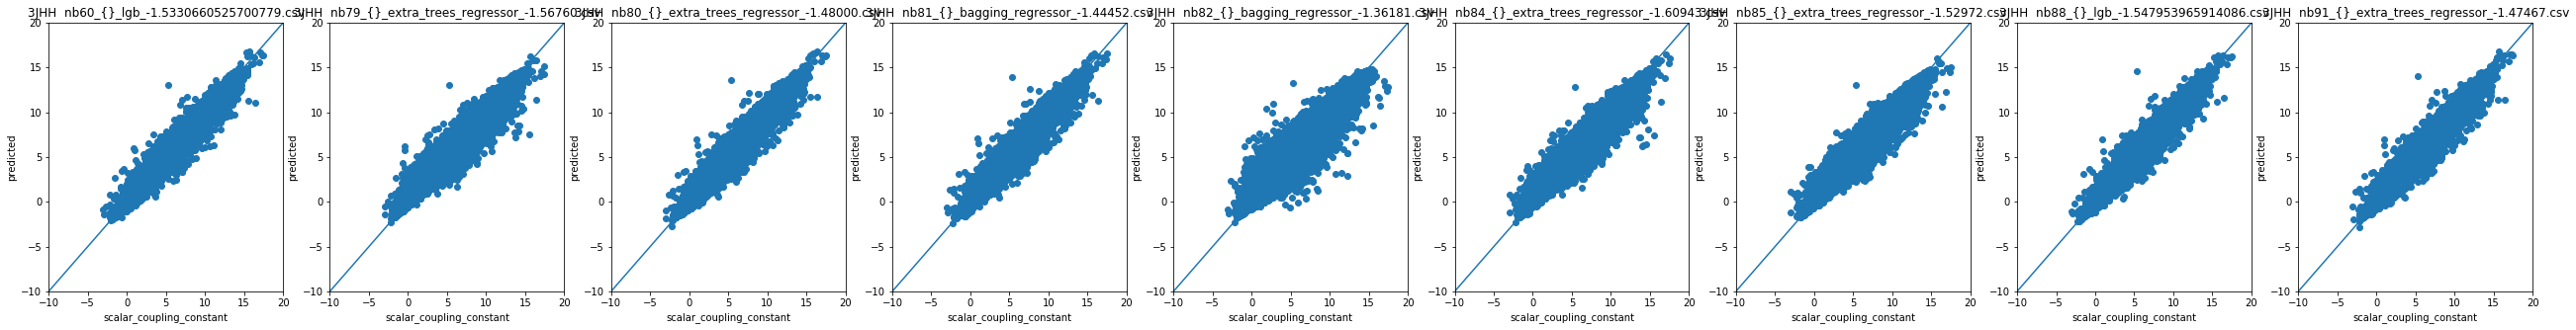

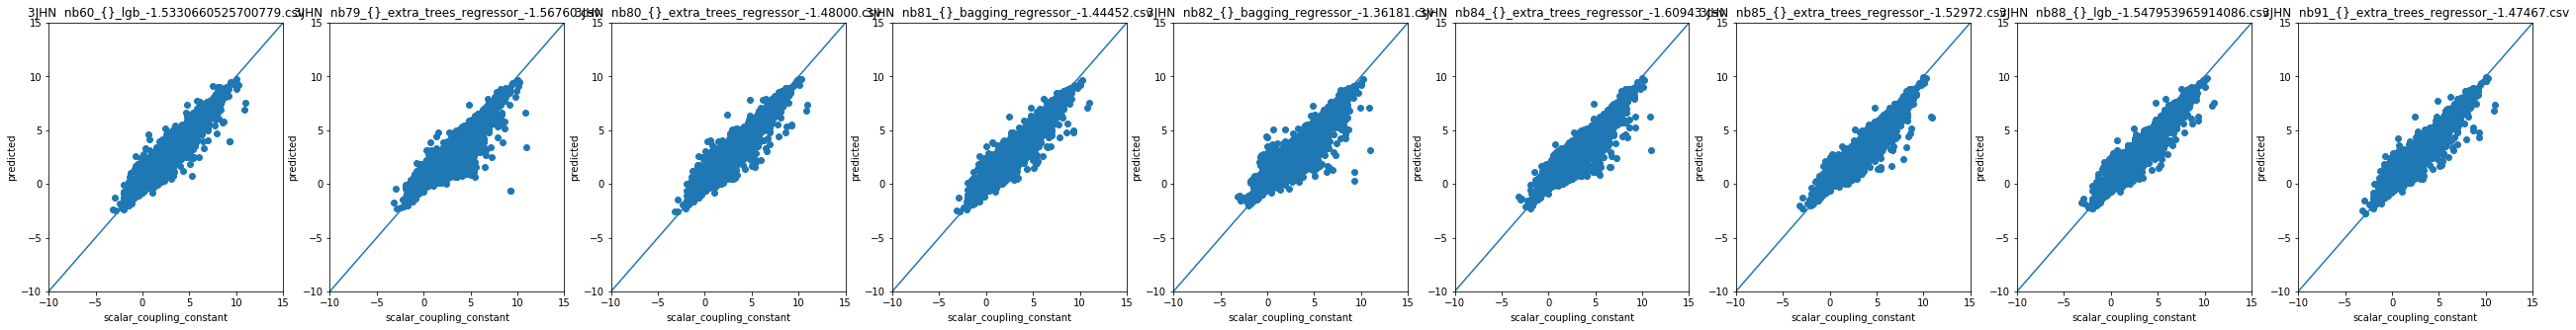

In [62]:
oof_list = [df.oof.values for df in oof_dfs ] 
model_names = path_list
# types = lbl.inverse_transform(X['type'])
types = type_train

def plot_oof_preds(ctype, llim, ulim):
    fig, axs = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
    axs = axs.ravel()
    for i in range(len(model_names)):
        model_name = model_names[i]
        t_idx = types==ctype
        y = train.scalar_coupling_constant.values
        axs[i].scatter(y[t_idx], oof_list[i][t_idx])
        axs[i].set_xlim((llim, ulim))
        axs[i].set_ylim((llim, ulim))
        axs[i].plot([llim, ulim], [llim, ulim])
        axs[i].set_xlabel('scalar_coupling_constant')
        axs[i].set_ylabel('predicted')
        axs[i].set_title(f'{ctype}  {model_names[i]}', fontsize=12)
        
plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 25)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -10, 20)
plot_oof_preds('3JHN', -10, 15)

## All function

metric

In [9]:
%%time
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [10]:
%%time
def kaggle_metric_faster(preds):
    maes = []
    for t in np.unique(type_train):
        idx = type_train == t
        mae = np.log(mean_absolute_error(scc[idx], preds[idx]))
        maes.append(mae)
    return np.mean(maes)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


# Blending
- meanとmedian blendingを行う

<br>
concat

In [11]:
concat_oof = pd.concat(oof_dfs, axis=1)
concat_sub = pd.concat(sub_dfs, axis=1)

<br>
blending

In [12]:
median_oof = concat_oof.median(axis=1).values
mean_oof = concat_oof.mean(axis=1).values

median_sub = concat_sub.median(axis=1).values
mean_sub = concat_sub.mean(axis=1).values

<br>
score

In [13]:
median = kaggle_metric(train, median_oof)
print(f'median: {median}')

mean = kaggle_metric(train, mean_oof)
print(f'mean:   {mean}')

median: -1.6884306737660313
mean:   -1.6818178845066987


## typeごとの組み合わせ

In [14]:
# create comb list
idx_path_list = np.arange(0, len(path_list))
comb_list = []
for n in range(2, len(path_list)+1):
    for idxes in itertools.combinations(idx_path_list, n):
        idxes = list(idxes)
        comb_list.append(idxes)
print(f'組み合わせ数: {len(comb_list)}')

組み合わせ数: 502


In [15]:
def compute_metrics(i):
    result_dict = {}
    comb = comb_list[i]
    
    # concat
    _oof_dfs = [oof_dfs[i] for i in comb]
#     _sub_dfs = [sub_dfs[i] for i in idxes]
    concat_oof = pd.concat(_oof_dfs, axis=1)
#     concat_sub = pd.concat(_sub_dfs, axis=1)
    
    type_dict = {}
    for type_ in type_train_list:
        score_dict = {}
        idx = type_train==type_
        mean_oof   = concat_oof[idx].mean(axis=1).values
        median_oof = concat_oof[idx].median(axis=1).values

        mean = np.log(mean_absolute_error(scc[idx], mean_oof))
    #     print(f'mean:   {mean}')

        median = np.log(mean_absolute_error(scc[idx], median_oof))
    #     print(f'median: {median} \n')

        score_dict['mean']    = mean
        score_dict['median'] = median
        type_dict[type_] = score_dict
    result_dict['comb']   = comb
#     result_dict['mean']   = mean
#     result_dict['median'] = median
    result_dict['type_dict'] = type_dict
    
    return result_dict

In [16]:
res = compute_metrics(33)
print(res['comb'])
res['type_dict']['2JHC']

[6, 7]


{'mean': -1.5653493615245027, 'median': -1.5653493615245027}

In [19]:
%%time
N_JOBS = 8
# p = Pool(N_JOBS)
# result_dict_list = p.map(compute_metrics, list(range(len(comb_list))))

# multiplocessing with fast_progress
with Pool(N_JOBS) as pool:
    lst = range(len(comb_list))
    imap = pool.imap(compute_metrics, lst)
    result_dict_list = list(progress_bar(imap, total=len(lst)))

CPU times: user 924 ms, sys: 438 ms, total: 1.36 s
Wall time: 4min 46s


In [20]:
# 1JHC
type_ = '1JHC'   # ===========================

l_comb   = []
l_mean   = []
l_median = []
for i in range(len(result_dict_list)):
    l_comb.append(result_dict_list[i]['comb'])
    l_mean.append(result_dict_list[i]['type_dict'][type_]['mean'])
    l_median.append(result_dict_list[i]['type_dict'][type_]['median'])
    
df_1JHC = pd.DataFrame({'comb': l_comb, 'mean': l_mean, 'median': l_mean})   # <==================

In [21]:
# 1JHN
type_ = '1JHN'   # ===========================

l_comb   = []
l_mean   = []
l_median = []
for i in range(len(result_dict_list)):
    l_comb.append(result_dict_list[i]['comb'])
    l_mean.append(result_dict_list[i]['type_dict'][type_]['mean'])
    l_median.append(result_dict_list[i]['type_dict'][type_]['median'])
    
df_1JHN = pd.DataFrame({'comb': l_comb, 'mean': l_mean, 'median': l_mean})   # <==================

In [22]:
# 2JHC
type_ = '2JHC'   # ===========================

l_comb   = []
l_mean   = []
l_median = []
for i in range(len(result_dict_list)):
    l_comb.append(result_dict_list[i]['comb'])
    l_mean.append(result_dict_list[i]['type_dict'][type_]['mean'])
    l_median.append(result_dict_list[i]['type_dict'][type_]['median'])
    
df_2JHC = pd.DataFrame({'comb': l_comb, 'mean': l_mean, 'median': l_mean})   # <==================

In [23]:
# 2JHH
type_ = '2JHH'   # ===========================

l_comb   = []
l_mean   = []
l_median = []
for i in range(len(result_dict_list)):
    l_comb.append(result_dict_list[i]['comb'])
    l_mean.append(result_dict_list[i]['type_dict'][type_]['mean'])
    l_median.append(result_dict_list[i]['type_dict'][type_]['median'])
    
df_2JHH = pd.DataFrame({'comb': l_comb, 'mean': l_mean, 'median': l_mean})   # <==================

In [24]:
# 2JHN
type_ = '2JHN'   # ===========================

l_comb   = []
l_mean   = []
l_median = []
for i in range(len(result_dict_list)):
    l_comb.append(result_dict_list[i]['comb'])
    l_mean.append(result_dict_list[i]['type_dict'][type_]['mean'])
    l_median.append(result_dict_list[i]['type_dict'][type_]['median'])
    
df_2JHN = pd.DataFrame({'comb': l_comb, 'mean': l_mean, 'median': l_mean})   # <==================

In [25]:
# 3JHC
type_ = '3JHC'   # ===========================

l_comb   = []
l_mean   = []
l_median = []
for i in range(len(result_dict_list)):
    l_comb.append(result_dict_list[i]['comb'])
    l_mean.append(result_dict_list[i]['type_dict'][type_]['mean'])
    l_median.append(result_dict_list[i]['type_dict'][type_]['median'])
    
df_3JHC = pd.DataFrame({'comb': l_comb, 'mean': l_mean, 'median': l_mean})   # <==================

In [26]:
# 3JHH
type_ = '3JHH'   # ===========================

l_comb   = []
l_mean   = []
l_median = []
for i in range(len(result_dict_list)):
    l_comb.append(result_dict_list[i]['comb'])
    l_mean.append(result_dict_list[i]['type_dict'][type_]['mean'])
    l_median.append(result_dict_list[i]['type_dict'][type_]['median'])
    
df_3JHH = pd.DataFrame({'comb': l_comb, 'mean': l_mean, 'median': l_mean})   # <==================

In [27]:
# 3JHN
type_ = '3JHN'   # ===========================

l_comb   = []
l_mean   = []
l_median = []
for i in range(len(result_dict_list)):
    l_comb.append(result_dict_list[i]['comb'])
    l_mean.append(result_dict_list[i]['type_dict'][type_]['mean'])
    l_median.append(result_dict_list[i]['type_dict'][type_]['median'])
    
df_3JHN = pd.DataFrame({'comb': l_comb, 'mean': l_mean, 'median': l_mean})   # <==================

In [29]:
method = 'mean'
top_comb_dict_mean = {}
top_comb_dict_mean['1JHC'] = df_1JHC.sort_values(by=method).reset_index().comb[0]
top_comb_dict_mean['1JHN'] = df_1JHN.sort_values(by=method).reset_index().comb[0]

top_comb_dict_mean['2JHC'] = df_2JHC.sort_values(by=method).reset_index().comb[0]
top_comb_dict_mean['2JHH'] = df_2JHH.sort_values(by=method).reset_index().comb[0]
top_comb_dict_mean['2JHN'] = df_2JHN.sort_values(by=method).reset_index().comb[0]

top_comb_dict_mean['3JHC'] = df_3JHC.sort_values(by=method).reset_index().comb[0]
top_comb_dict_mean['3JHH'] = df_3JHH.sort_values(by=method).reset_index().comb[0]
top_comb_dict_mean['3JHN'] = df_3JHN.sort_values(by=method).reset_index().comb[0]

In [30]:
method = 'median'
top_comb_dict_median = {}
top_comb_dict_median['1JHC'] = df_1JHC.sort_values(by=method).reset_index().comb[0]
top_comb_dict_median['1JHN'] = df_1JHN.sort_values(by=method).reset_index().comb[0]

top_comb_dict_median['2JHC'] = df_2JHC.sort_values(by=method).reset_index().comb[0]
top_comb_dict_median['2JHH'] = df_2JHH.sort_values(by=method).reset_index().comb[0]
top_comb_dict_median['2JHN'] = df_2JHN.sort_values(by=method).reset_index().comb[0]

top_comb_dict_median['3JHC'] = df_3JHC.sort_values(by=method).reset_index().comb[0]
top_comb_dict_median['3JHH'] = df_3JHH.sort_values(by=method).reset_index().comb[0]
top_comb_dict_median['3JHN'] = df_3JHN.sort_values(by=method).reset_index().comb[0]

In [31]:
print(top_comb_dict_mean)
print(top_comb_dict_median)

{'1JHC': [0, 5, 7], '1JHN': [0, 5, 7], '2JHC': [0, 1, 5, 7], '2JHH': [0, 5, 7], '2JHN': [1, 5, 6, 7], '3JHC': [0, 5, 6, 7], '3JHH': [0, 1, 5, 6, 7], '3JHN': [0, 1, 5, 6, 7]}
{'1JHC': [0, 5, 7], '1JHN': [0, 5, 7], '2JHC': [0, 1, 5, 7], '2JHH': [0, 5, 7], '2JHN': [1, 5, 6, 7], '3JHC': [0, 5, 6, 7], '3JHH': [0, 1, 5, 6, 7], '3JHN': [0, 1, 5, 6, 7]}


# compute with best combs each type

In [32]:
top_comb_dict = top_comb_dict_median   # <=============
best_oof = pd.DataFrame({'type': type_train, 'oof': [0]*len(type_train)})
best_sub = pd.DataFrame({'type': type_test, 'scalar_coupling_constant': [0]*len(type_test)})
for type_ in type_train_list:
    best_comb = top_comb_dict[type_]
    
    _oof_dfs = [oof_dfs[i] for i in best_comb]
    _sub_dfs = [sub_dfs[i].scalar_coupling_constant for i in best_comb]
    concat_oof = pd.concat(_oof_dfs, axis=1)[type_train==type_]
    concat_sub = pd.concat(_sub_dfs, axis=1)[type_test==type_]

    # compute median and mean value
    median_oof = concat_oof.median(axis=1).values
    median_sub = concat_sub.median(axis=1).values
    
    best_oof.loc[type_train==type_, 'oof'] = median_oof
    best_sub.loc[type_test==type_, 'scalar_coupling_constant'] = median_sub
    

In [34]:
oof_score = kaggle_metric_faster(best_oof.oof.values)
oof_score

# save

---
submission

In [41]:
save_score = oof_score
save_pred  = best_sub.scalar_coupling_constant

path_submission = f'./../output/nb{nb}_blend_submission_{save_score}.csv'
print(f'save path : {path_submission}')

save path : ./../output/nb90_blend_submission_-1.7424999215262091.csv


In [42]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
if isSmallSet:
    pass
else:
    submittion['scalar_coupling_constant'] = save_pred
    submittion.to_csv(path_submission, index=False)

---
**result**

In [44]:
path_oof = f'./../output/nb{nb}_blend_oof_{save_score}.csv'
print(f'save path : {path_oof}')

save path : ./../output/nb90_blend_oof_-1.7424999215262091.csv


In [45]:
oof = pd.DataFrame({'oof': best_oof.oof.values})
if isSmallSet:
    pass
else:
    oof.to_csv(path_oof, index=False)

# analysis

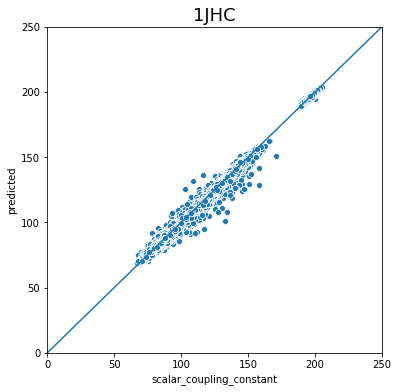

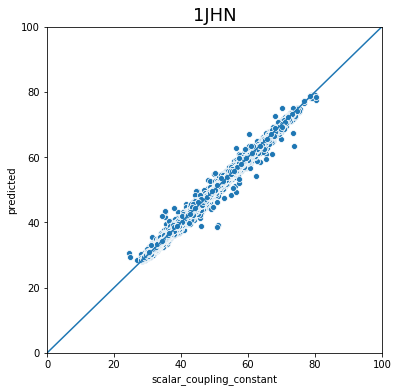

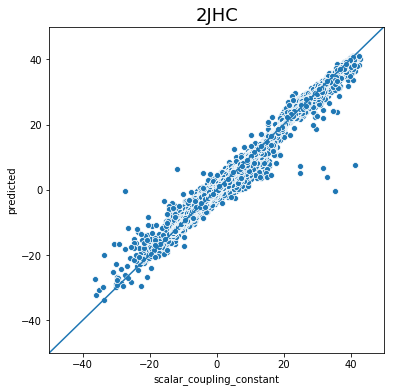

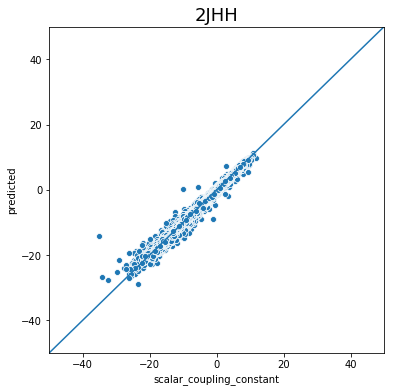

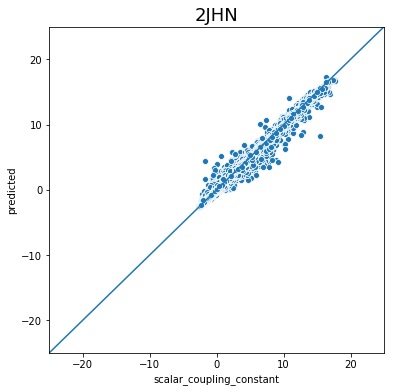

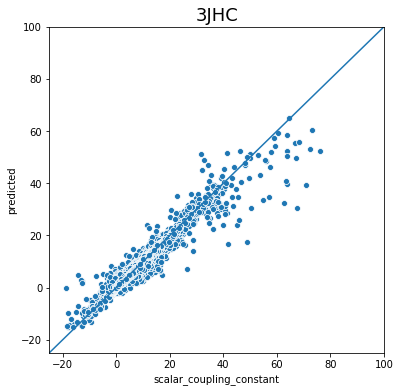

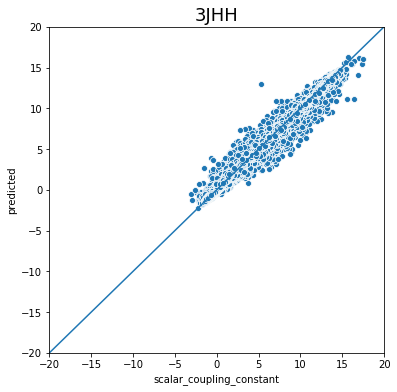

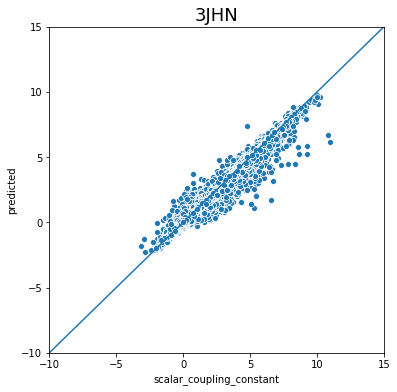

In [37]:
plot_data = pd.DataFrame(scc, columns=['scalar_coupling_constant'])
plot_data.index.name = 'id'
plot_data['yhat'] = best_oof.oof.values
plot_data['type'] = type_train

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)